# 1. Getting the Data
Let us start by importing the train and test data sets using pandas library and extract the input and target dataframes (X and y).

In [2]:
import numpy as np
import pandas as pd
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


y → We can easily deduce that the 'Survived' column is the final outcome and is therefore dependent on other values.

X → The rest of columns are part of the independent set.

In [0]:
X = train.drop('Survived',axis=1)
X_test = test.copy(deep=True)
y = train.Survived

# 2. Visualization
Let us visualize some things to get a clear understanding of the data.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


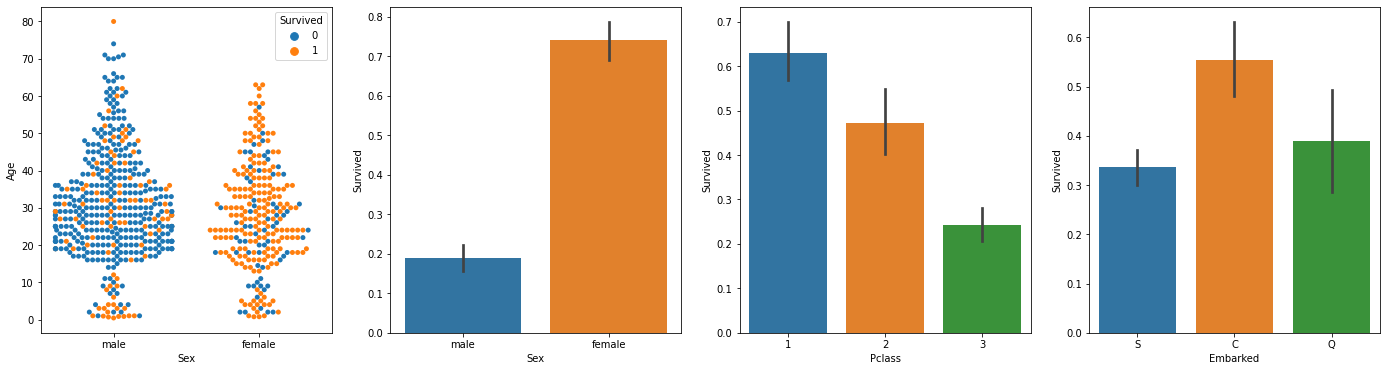

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,a =  plt.subplots(1, 4, figsize = (24,6))
sns.swarmplot(x = X.Sex, y = X.Age, hue = y, ax = a[0])
sns.barplot(x = X.Sex, y = y, ax = a[1])
sns.barplot(x = X.Pclass, y = y,ax = a[2])
sns.barplot(x = X.Embarked, y = y, ax = a[3])

1. We see that males or boys under the age of 12 survived compared to those older than them.
2. Most of the women survived.
3. Survivability of passengers when it comes to their class is: Class 1 > Class 2 > Class 3.
4. Passengers from C(Cherbourg) survived more than those who embarked Q(Queenstown) and passengers who got on at S(Southampton) survived the least.

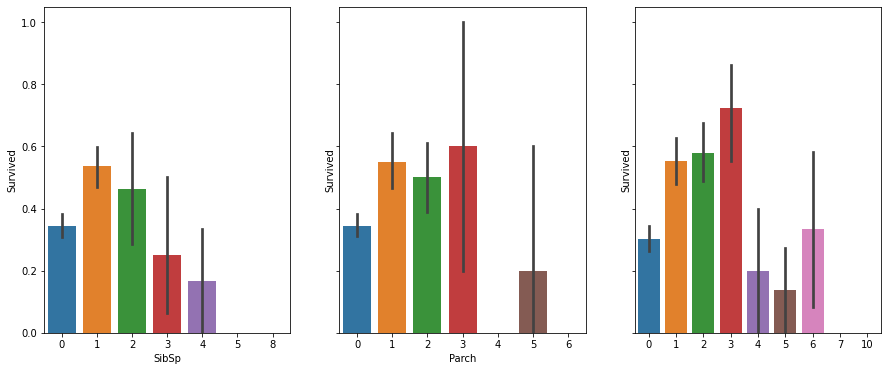

In [5]:
family_count = [X.Parch[i] + X.SibSp[i] for i in range(len(X[:]))]
fig,a =  plt.subplots(1, 3, figsize = (15,6), sharey=True)
sns.barplot(x = X.SibSp, y = y, ax = a[0])
sns.barplot(x = X.Parch, y = y, ax = a[1])
sns.barplot(x = family_count, y = y, ax = a[2])

Based on the number of people in the family (Parents, children or sibling), we can conclude that survivability of people with:
1. Siblings - 1 > 2 > 0 > 3 > 4 > 5 = 8
2. Parents/Children - 3 > 1 > 2 > 0 > 5 > 4 = 6
3. Total family members - 3 > 2 > 1 > 6 > 0 > 4 > 5 > 7 = 10

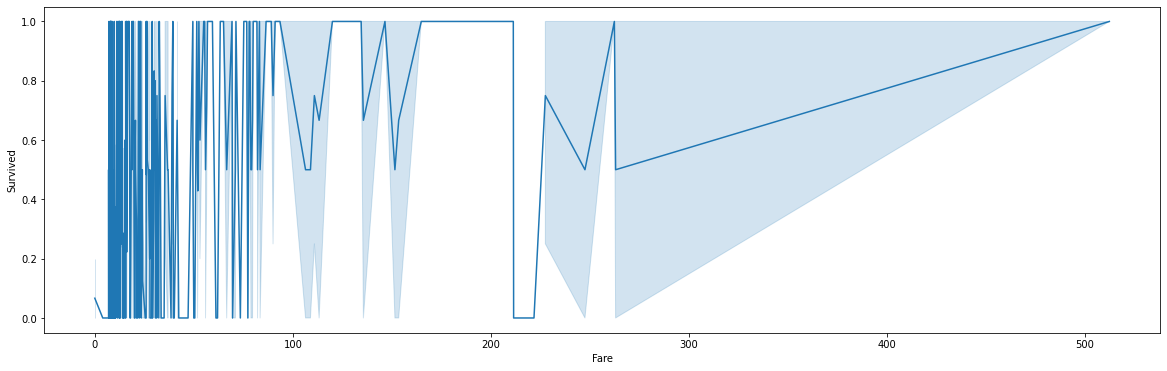

In [6]:
plt.figure(figsize=(20,6))
sns.lineplot(x = X.Fare, y = y)

It looks like most people who paid more than 70, had a higher chance of survival.

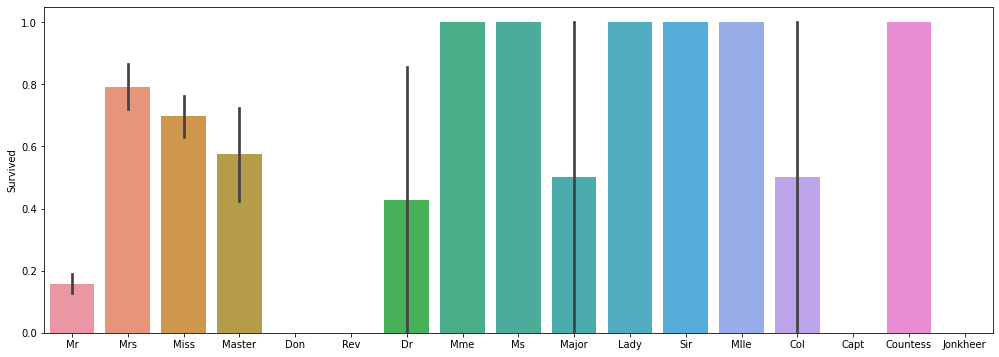

In [7]:
names = [i[:i.index('.')].split()[-1] for i in X.Name]
plt.figure(figsize=(17,6))
sns.barplot(x=names, y=y)

From the graph, we can assume:
* People with titles Ms, Miss, Lady, Mrs, Mlle, Mme, Countess and Col had a high chance of survival.
* People with titles Sir, Mr, Master, Major, Capt, Rev, Dr, Don, Dona and Jonkheer had a lesser chance of survival.

# 3. Feature engineering and Data preprocessing
During Visualisation we created a list 'names' - containing titles of the passsengers. Let us include this in our data; by replacing the 'Name' column.

In [8]:
for data in [X, X_test]:
    names = [i[:i.index('.')].split()[-1] for i in data.Name]
    data.Name = names
X.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,2,Rev,male,27.0,0,0,211536,13.00,NaN,S
887,888,1,Miss,female,19.0,0,0,112053,30.00,B42,S
888,889,3,Miss,female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,Mr,male,26.0,0,0,111369,30.00,C148,C
890,891,3,Mr,male,32.0,0,0,370376,7.75,NaN,Q


Let us now find the columns with missing data in both test and train data sets.

In [9]:
for data in [X, X_test]:
    missing_val_count_by_column = (data.isnull().sum())
    print(missing_val_count_by_column[missing_val_count_by_column > 0],'\n')

Age         177
Cabin       687
Embarked      2
dtype: int64 

Age       86
Fare       1
Cabin    327
dtype: int64 



'Cabin' contains a lot of missing data. It would be a better option to drop the column.

Missing values of 'Age', and 'Fare' can be replaced by their mean and that of 'Embarked' by the mode.

In [0]:
X.drop('Cabin', axis=1, inplace = True)
X_test.drop('Cabin', axis=1, inplace = True)
X.Age.fillna(X.Age.mean() + X_test.Age.mean(), inplace = True)
X_test.Age.fillna(X.Age.mean() + X_test.Age.mean(), inplace = True)
X_test.Fare.fillna(X.Fare.mean() + X_test.Fare.mean(), inplace = True)
X.Embarked.replace({np.nan:'S'},inplace = True)

There are columns here that should not affect the survivability of a passengers such as 'PassengerId' and 'Ticket'. Let us drop these columns and then process the data based on observations made during visualization.

We perform feature scaling at the end, to normalize the data.

In [0]:
for data in [X, X_test]:    
    data.drop(columns=['PassengerId','Ticket'],inplace = True)
    data['Pclass'] = data['Pclass'].replace({1:3,3:1})
    data['Name'] = data['Name'].replace({'Ms':'Miss', 'Lady':'Mrs', 'Mlle':'Miss', 'Mme':'Miss', 'Countess':'Miss', 'Sir':'Mr', 'Master':'Mr'})
    data['Name'] = data['Name'].replace({'Major':'N', 'Col':'Y', 'Capt':'N',  'Rev':'N', 'Dr':'N','Don':'N','Dona':'N','Jonkheer':'N'})
    data['Name'] = data['Name'].replace({'N':0,'Mr':1,'Mrs':2,'Miss':2,'Y':3})
    data.Sex.replace({'male':0,'female':1},inplace = True)
    li = []
    for i in range(len(data[:])):
        k = data['Parch'][i]+data['SibSp'][i]
        if k>3:
            li.append(4)
        else:
            li.append(k)
    data.Parch = li
    data.Parch = data.Parch.replace({4:0,0:1,1:2,2:3,3:4})
    li = []
    for i in range(len(data[:])):
        k = data['SibSp'][i]
        if k>4:
            li.append(5)
        else:
            li.append(k)
    data.SibSp = li
    data.SibSp = data.SibSp.replace({5:0,4:1,3:2,0:3,2:4,1:5})
    data.Embarked.replace({'C':3,'Q':2,'S':1},inplace = True)
    data.Fare = data.Fare > 70
    data.Fare = data.Fare.replace({True:1,False:0})
    AD = (data.Age < 15).replace({True:1,False:0})
    data['AD'] = AD

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = sc.transform(X_test)

# 4. Modelling and Prediction
We can construct various models and perform parameter tuning to increase their accuracy.
1. Random Forest Classifier

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfc_param_grid = { 
    'n_estimators': [6,7,8,9],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth' : [3,4,5,6],
    'criterion' : ['gini','entropy']
}
rfc_grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = rfc_param_grid, cv = 10, n_jobs = -1)
rfc_grid_search.fit(X, y)
print('Best parameters:',rfc_grid_search.best_params_)
print('Accuracy:',rfc_grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 6}
Accuracy: 0.8327715355805243


2. eXtreme Gradient Boosting Classifier

In [13]:
from xgboost import XGBClassifier

xgbc_param_grid = {    
        'learning_rate' : [0.001, 0.005],
        'n_estimators' : [2, 3, 4],
        'min_child_weight': [1, 2, 3],
        'gamma': [0.001, 0.01, 0.1],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'max_depth': [1, 2, 3, 4]
}
xgbc_grid_search = GridSearchCV(estimator = XGBClassifier(), param_grid = xgbc_param_grid, cv = 5, n_jobs = -1)
xgbc_grid_search.fit(X, y)
print('Best parameters:',xgbc_grid_search.best_params_)
print('Accuracy:',xgbc_grid_search.best_score_)

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.001, 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 3, 'subsample': 0.7}
Accuracy: 0.8293955181721173


3. Support Vector Classifier

In [14]:
from sklearn.svm import SVC

svc_param_grid = {
    'C': [0.2, 0.3, 0.4, 0.5],
    'gamma': [0.05, 0.1, 0.5],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
svc_grid_search = GridSearchCV(estimator = SVC(), param_grid = svc_param_grid,cv = 10, n_jobs = -1)
svc_grid_search.fit(X, y)
print('Best parameters:',svc_grid_search.best_params_)
print('Accuracy:',svc_grid_search.best_score_)

Best parameters: {'C': 0.4, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.8294007490636703


We can stack these classifiers to increase the accuracy even further.

In [15]:
from vecstack import stacking
from sklearn.metrics import accuracy_score

models = [     
    RandomForestClassifier(criterion = 'gini', max_depth = 5, max_features = 'log2', n_estimators = 6, n_jobs=-1),
    XGBClassifier(colsample_bytree = 0.8, gamma = 0.001, learning_rate = 0.001, max_depth = 3, min_child_weight = 1, n_estimators = 3, subsample = 0.7, n_jobs=-1),
    SVC(C = 0.4, gamma = 0.1, kernel = 'rbf'),
]

S_train, S_test = stacking(models, X, y, X_test,
                           regression = False, mode = 'oof_pred_bag',
                           needs_proba = False, save_dir = None,
                           metric = accuracy_score, n_folds = 10,
                           stratified = True, shuffle = True,
                           random_state = 0, verbose = 2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestClassifier]
    fold  0:  [0.86666667]
    fold  1:  [0.85393258]
    fold  2:  [0.80898876]
    fold  3:  [0.88764045]
    fold  4:  [0.85393258]
    fold  5:  [0.83146067]
    fold  6:  [0.73033708]
    fold  7:  [0.80898876]
    fold  8:  [0.79775281]
    fold  9:  [0.80898876]
    ----
    MEAN:     [0.82486891] + [0.04224719]
    FULL:     [0.82491582]

model  1:     [XGBClassifier]
    fold  0:  [0.86666667]
    fold  1:  [0.84269663]
    fold  2:  [0.84269663]
    fold  3:  [0.88764045]
    fold  4:  [0.85393258]
    fold  5:  [0.82022472]
    fold  6:  [0.73033708]
    fold  7:  [0.80898876]
    fold  8:  [0.77528090]
    fold  9:  [0.82022472]
    ----
    MEAN:     [0.82486891] + [0.04342606]
    FULL:     [0.82491582]

model  2:     [SVC]
    fold  0:  [0.87777778]
    fold  1:  [0.85393258]
    fold  2:  [0.83146067]
    

The last XGBClassification model is built using outputs of the first three. This stacked model will be the most accurate.

In [0]:
final_param_grid = {
        'min_child_weight': [1, 2],
        'learning_rate' : [0.001, 0.005],
        'n_estimators' : [4, 5, 6],
        'gamma': [0.0005, 0.001],
        'subsample': [0.1, 0.2, 0.3],
        'colsample_bytree': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [1, 2]}
final_grid_search = GridSearchCV(estimator = XGBClassifier(), param_grid = final_param_grid, 
                           cv = 10, n_jobs = -1)
final_grid_search.fit(S_train, y)

We perform predictions on the TEST DATA using the final model.

In [0]:
final_model = final_grid_search.best_estimator_
sol = final_model.predict(S_test)
sol = np.column_stack((test.PassengerId,sol))
sol = pd.DataFrame(data=sol,columns=['PassengerId','Survived'])
sol.to_csv('Data/Solution.csv', index = False)